# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:
* tokenize with MWEs using spacy
* estimate LDA topic models with tomotopy
* visualize and evaluate topic models
* apply topic models to interpretation of hotel reviews

## Build topic model

In [2]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

### Read in hotel review data and tokenize it

In [3]:
df = pd.read_parquet('hotels.parquet')

In [4]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('hotel-terms.txt'))

Select a sample of reviews to work with (replace x's below with the sample size; you should use at least 50,000 reviews)

In [5]:
# Get list of tokens
tokenizer.tokenize(df['text'].iloc[0])

['stayed',
 'in',
 'a',
 'king_suite',
 'for',
 '11',
 'nights',
 'and',
 'yes',
 'it',
 'cots',
 'us',
 'a',
 'bit',
 'but',
 'we',
 'were',
 'happy',
 'with',
 'the',
 'standard',
 'of',
 'room',
 'the',
 'location',
 'and',
 'the',
 'friendliness',
 'of',
 'the',
 'staff',
 'our',
 'room',
 'was',
 'on',
 'the',
 '20th',
 'floor',
 'overlooking',
 'broadway',
 'and',
 'the',
 'madhouse',
 'of',
 'the',
 'fairway',
 'market',
 'room',
 'was',
 'quite',
 'with',
 'no',
 'noise',
 'evident',
 'from',
 'the',
 'hallway',
 'or',
 'adjoining',
 'rooms',
 'it',
 'was',
 'great',
 'to',
 'be',
 'able',
 'to',
 'open',
 'windows',
 'when',
 'we',
 'craved',
 'fresh',
 'rather',
 'than',
 'heated',
 'air',
 'the',
 'beds',
 'including',
 'the',
 'fold',
 'out',
 'sofa_bed',
 'were',
 'comfortable',
 'and',
 'the',
 'rooms',
 'were',
 'cleaned',
 'well',
 'wi-fi',
 'access',
 'worked',
 'like',
 'a',
 'dream',
 'with',
 'only',
 'one',
 'connectivity',
 'issue',
 'on',
 'our',
 'first_night',


In [6]:
subdf = df.sample(75000)

In [7]:
subdf['tokens'] = pd.Series(subdf['text'].progress_apply(tokenizer.tokenize))

  0%|          | 0/75000 [00:00<?, ?it/s]

### Let's build a Topic Model!
### Estimate model

In [8]:
import tomotopy as tp
import time

These are the model **hyperparameters**: aspects of the model that aren't estimated from the data but have to be set in advance by the analyst. There's no "right" values for these. You'll just have to try out different values to find settings that give you a model that you can interpret:

* *k* = number of topics
* *min_df* = minimum number of reviews that a term has to occur in to be included in the model
* *rm_top* = number of most frequent terms to remove from the model
* *tw* = term weighting strategy (described [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.TermWeight)]
* *alpha*, *eta* = priors for document-topic and topic-word distributions
* *tol* = convergence tolerance


In [49]:
k = 100
min_df = 10
rm_top = 40
tw = tp.TermWeight.ONE  # Weights terms the same
alpha = 0.1
eta = 0.01
tol = 1e-3

Here's where we do the inference (estimation code). The documentation for `LDAModel` is [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.LDAModel). You might also consider trying out one of the other model types (e.g., `HDPModel`).

In [50]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in subdf['tokens']:
    if doc:
        mdl.add_doc(doc)

last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f'{i:5d} LL = {ll:7.4f}', flush=True) # LL per word
    if ll - last < tol:
        break
    else:
        last = ll

print(f'Done!')

    0 LL = -9.2364
   50 LL = -8.9797
  100 LL = -8.8837
  150 LL = -8.8330
  200 LL = -8.8010
  250 LL = -8.7802
  300 LL = -8.7667
  350 LL = -8.7547
  400 LL = -8.7456
  450 LL = -8.7392
  500 LL = -8.7322
  550 LL = -8.7305
  600 LL = -8.7274
  650 LL = -8.7249
  700 LL = -8.7212
  750 LL = -8.7196
  800 LL = -8.7184
  850 LL = -8.7192
Done!
CPU times: user 42min 39s, sys: 13.1 s, total: 42min 52s
Wall time: 14min 33s


### Evaluate the model

What terms are associated with each topic?

In [51]:
for k in range(mdl.k):
    print(f'{k:3d} ', ', '.join(s for s,_ in mdl.get_topic_words(k)))

  0  la, hollywood, blvd, theater, pool, los_angeles, center, santa_monica, universal_studios, parking
  1  business, hotels, one, me, stayed, best, travel, hyatt, am, when
  2  restaurants, within, walking_distance, great, many, close, location, shopping, area, also
  3  $, night, per, day, parking, charge, pay, cost, internet, no
  4  when, up, front_desk, me, us, called, out, back, told, after
  5  recommend, staff, highly, helpful, friendly, great, clean, location, rooms, comfortable
  6  star, 5, 4, star_hotel, stars, 3, five, hotels, if, give
  7  which, good, really, new_york, clean, breakfast, only, its, staff, 5
  8  staff, helpful, always, us, friendly, help, any, every, questions, concierge
  9  suite, bedroom, area, kitchen, two, large, microwave, suites, living_room, one
 10  reviews, after, about, read, other, some, did, reading, booked, based
 11  she, her, me, said, asked, when, told, front_desk, us, lady
 12  after, us, day, staff, stayed, nights, which, trip, just, co

Which terms got remove due to `rm_top`?

In [52]:
', '.join(mdl.removed_top_words)

"the, and, a, to, was, i, in, we, of, is, for, it, not, hotel, at, room, were, that, but, on, with, this, very, you, had, have, there, my, our, are, from, they, as, so, would, stay, be, all, do, 's"

Visualize topic model with LDAvis

In [53]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k)
                             for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,
                                 doc_topic_dists,
                                 doc_lengths,
                                 vocab,
                                 term_frequency, 
                                 mds='tsne', 
                                 sort_topics=False
                                 )

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [54]:
pyLDAvis.display(prepared_data)

Find documents that best represent each topic

In [55]:
for i,d in enumerate(np.argmax(doc_topic_dists, axis=0)):
    print(i, ', '.join(map(first, mdl.get_topic_words(i))))
    print(subdf['text'].iloc[d])
    print()

0 la, hollywood, blvd, theater, pool, los_angeles, center, santa_monica, universal_studios, parking
This was my first time in LA and being based on the corner of Hollywood and Highland was an ideal spot. We were given a high floor overlooking the Hollywood sign.
The metro was a few metres away and we rode this one stop to Universal STudios - so easy
The Chinese Theatre is full of characters and I would defintely stay here again

1 business, hotels, one, me, stayed, best, travel, hyatt, am, when
I'm a business traveler and I spend a considerable amount of time in hotels and in the Chicago area and across the country. I am come to truly value the distinct experience I feel when I stay at Hyatt hotels. So when I meet staff members like Jason Jones who go above and beyond to bring quality and a smile while representing their hotel, I am assured that there are few and far options for me aside for this hotel for my business travels. The Hyatt Regency Chicago is truly and excellent hotel and 

Generate word clouds for topics

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

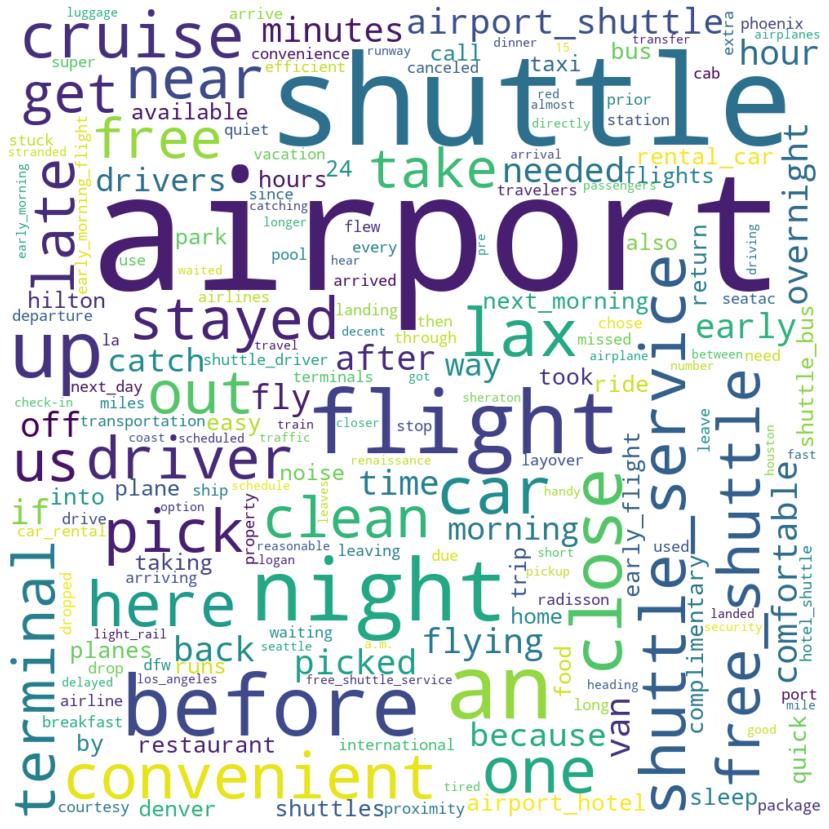

In [57]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(54, 200))
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Save the final, best model

In [58]:
mdl.save('hotel-topics.bin')